<a href="https://colab.research.google.com/github/anomaitech/GeoApp/blob/main/pysheds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysheds


In [2]:
import rasterio
from pysheds.grid import Grid
from rasterio.plot import show
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np

In [3]:
downscale_factor = 20

with rasterio.open('/content/elevation.tiff') as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height / downscale_factor),
            int(dataset.width / downscale_factor)
        ),
        out_dtype='uint16'
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    profile = dataset.profile
    profile['nodata'] = '0'
    profile['dtype'] = 'uint16'
    profile['transform'] = transform
    profile['width'] = int(dataset.width / downscale_factor)
    profile['height'] = int(dataset.height / downscale_factor)

In [4]:
with rasterio.open('/content/dtm_10.tif', 'w', **profile) as dst:
    dst.write(np.squeeze(data), 1)

In [5]:
dataset = rasterio.open('/content/dtm_10.tif')


In [ ]:
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [ ]:
import numpy as np

In [ ]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
dem.nodata = -9999  # Or whatever your actual nodata value is
grid.nodata = -9999

# Calculate flow direction, specifying the desired data type
fdir = grid.flowdir(inflated_dem, dirmap=dirmap, nodata_out=np.int32(-9999)) # Or another appropriate integer type like np.int16

In [ ]:
import matplotlib.pyplot as plt

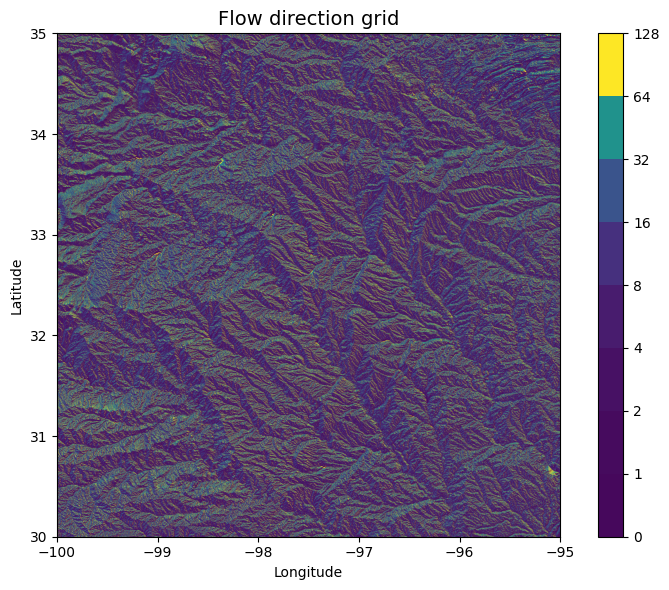

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [ ]:
import numpy as np

# Use numpy types for nodata values, ensuring they are 64-bit
dem.nodata = np.int64(-9999)
grid.nodata = np.int64(-9999)

# Calculate flow direction with explicit 64-bit type handling
fdir = grid.flowdir(
    inflated_dem,
    dirmap=dirmap,
    nodata_out=np.int64(-9999),  # Must match array dtype
    dtype=np.int64  # Explicitly set output type to 64-bit
)

# Calculate accumulation with matching 64-bit types
acc = grid.accumulation(
    fdir,
    dirmap=dirmap,
    nodata_out=np.int64(-9999),  # Specify nodata_out with the correct type
    dtype=np.int64  # Must match flowdir's data type, use 64-bit
)


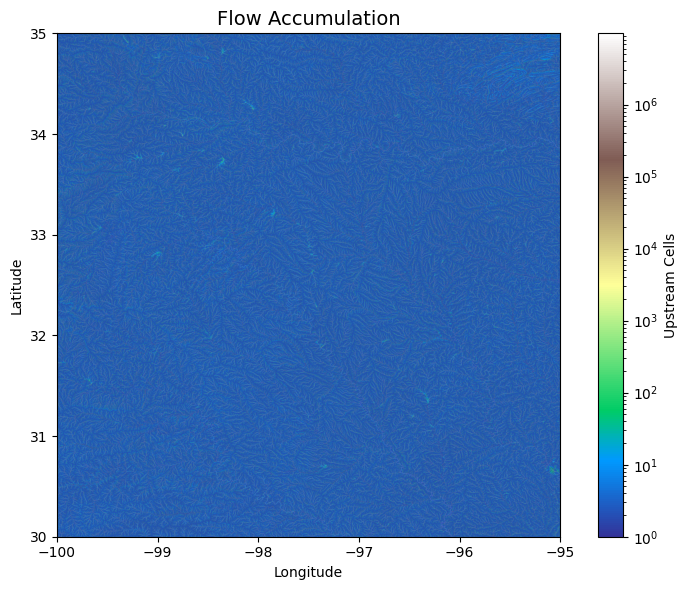

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)

# Try different colormaps, e.g., 'terrain', 'viridis', 'plasma', 'inferno'
cmap = 'terrain'

# Adjust normalization for better visualization
# You can try different vmin and vmax values or use a different normalization method like PowerNorm
norm = colors.LogNorm(vmin=1, vmax=acc.max())

im = ax.imshow(
    acc,
    extent=grid.extent,
    zorder=2,
    cmap=cmap,
    norm=norm,
    interpolation='bilinear'
)

plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [ ]:
x, y = -97.294, 32.737

def get_nodata(dtype):
    """Determine appropriate nodata value based on dtype."""
    if np.issubdtype(dtype, np.floating):
        return np.nan
    else:
        # For integer types, check if -9999 is valid, else use min/max
        if np.issubdtype(dtype, np.signedinteger):
            info = np.iinfo(dtype)
            return -9999 if info.min <= -9999 <= info.max else info.min
        else:  # Unsigned integer
            return np.iinfo(dtype).max

# Set nodata for accumulation grid (assuming `acc` is a numpy array)
acc.nodata = get_nodata(acc.dtype)

# Set nodata for sGrid using its underlying data (e.g., flow direction grid)
# Assuming `fdir` is the numpy array behind the `sGrid`
grid.nodata = get_nodata(fdir.dtype)  # Use dtype of the flow direction grid

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Crop and plot the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

TypeError: `nodata` value not representable in dtype of array.